# Infer ***mitochondria*** - part 5️⃣

--------------
OBJECTIVE: ✅ Infer sub-cellular component  ***mitochondria***  in order to understand interactome 

Dependencies:
The ***mitochondria***  inference rely on the ***cytosol*** mask


# IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff, 
                                                                    etree_to_dict, 
                                                                    save_parameters, 
                                                                    load_parameters, 
                                                                    export_ndarray)
from infer_subc_2d.utils.img import *
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )        
from infer_subc_2d.organelles.soma import infer_soma
from infer_subc_2d.organelles.nuclei import infer_nuclei
from infer_subc_2d.organelles.cytosol import infer_cytosol

%load_ext autoreload
%autoreload 2

test_img_n = 5

# BUILD ***mitochondria*** inference image processing workflow

## IMAGE PROCESSING Objective 5:  infer ***mitochondria***


### summary 

Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter Tom20as a potential Mitochondria segmenter to start with  start from [Allen Cell](https://www.allencell.org/cell-observations/category/mitochondria).   using [seg_tomm20.py]("../../../../aics-segmentation/aicssegmentation/structure_wrapper/seg_tomm20.py")

### steps

INPUT
- channel  2
- cytosol mask

PRE-PROCESSING
-  smoothe / remove noise

CORE-PROCESSING
-  'vesselness' enhancement
-  threshold objects

- POST-PROCESSING
  - apply mask
  - filter objects

OUTPUT
- inferred  ***mitochondria*** object




------------------------
## LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [2]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [3]:
# lets see if napari is smart enough with scale...

# # make sure we have removed Z
# if len(scale)>2:
#     scale = scale[1:]

## CHOOZE Z-SLICE



First, find the slice with the most overall intensity...

In [4]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 



Now get the single "optimal" slice of all our organelle channels....

In [5]:
img_2D = img_data[:,[optimal_Z],:,:].copy()

## Collect the ***cytosol*** mask

i.e. inferred soma, nuclei and cytosol objects

(takes < 1 sec)

In [6]:

soma_mask =  infer_soma(img_2D) 
nuclei_object =  infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


## Build  ***Mitochondria***  specific inference workflow



### INPUT

In [7]:

###################
# INPUT
###################
raw_mito    = img_2D[MITO_CH].copy()


### PRE-PROCESSING

In [8]:
###################
# PRE_PROCESSING
###################

# intensity_norm_param = [0, 9] # from Allen Cell Segmenter LAMP1  workflow
# struct_img = intensity_normalization( raw_mito ,  scaling_param=intensity_norm_param)

struct_img = min_max_intensity_normalization( raw_mito)




In [9]:

med_filter_size = 3  

gaussian_smoothing_sigma = 1.3
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter_slice_by_slice(struct_img,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


# log_img, d = log_transform( structure_img_smooth ) 
# struct_img = intensity_normalization(  log_img  ,  scaling_param=[0] )  

struct_img = structure_img_smooth

### CORE PROCESSING

In [10]:
###################
# CORE_PROCESSING
###################
# dot and filiment enhancement - 2D


################################
## PARAMETERS for this step ##
vesselness_sigma = [1.5]
vesselness_cutoff = 0.05
# 2d vesselness slice by slice
response = vesselness_slice_by_slice(structure_img_smooth, sigmas=vesselness_sigma, cutoff=-1, tau=.75)
bw = vesselness_slice_by_slice(structure_img_smooth, sigmas=vesselness_sigma, cutoff=vesselness_cutoff, tau=.75)


# # from Sec61b workflows - playground references Tom20
# f2_param = [[1.5, 0.16]]
# bw = filament_2d_wrapper(structure_img_smooth, f2_param)

### POST-PROCESSING

In [11]:

# # 3D
###################
# POST_PROCESSING
###################

################################

mito_object = apply_mask(bw,cytosol_mask)


small_object_max = 3

mito_object = size_filter_2D(mito_object, 
                                                min_size= small_object_max**2, 
                                                connectivity=1)


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [12]:
viewer = napari.Viewer()



In [13]:


viewer.add_image(
    raw_mito,
    scale=scale
)

viewer.scale_bar.visible = True
viewer.add_image(
    structure_img_smooth,
    scale=scale
)


<Image layer 'structure_img_smooth' at 0x14aed47c0>

In [14]:

viewer.add_image(
    mito_object,
    scale=scale
)


<Image layer 'mito_object' at 0x16c5836d0>

In [15]:


viewer.add_image(
    response,
    scale=scale
)


viewer.add_image(
    bw,
    scale=scale
)


<Image layer 'bw' at 0x17ef8c7f0>

### Collect into a single `infer_mitochondria` function

In [16]:
##########################
#  infer_mitochondria
##########################
def _infer_mitochondria(in_img: np.ndarray, cytosol_mask: np.ndarray) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    cytosol_mask: np.ndarray
        mask of cytosol

    Returns:
    -------------
    lysosome_object
        mask defined extent of mitochondria object
    
    """
 
   
    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = min_max_intensity_normalization(in_img[MITO_CH].copy())

    med_filter_size = 3
    struct_img = median_filter_slice_by_slice(struct_img, size=med_filter_size)

    gaussian_smoothing_sigma = 1.34
    gaussian_smoothing_truncate_range = 3.0
    struct_img = image_smoothing_gaussian_slice_by_slice(
        struct_img, sigma=gaussian_smoothing_sigma, truncate_range=gaussian_smoothing_truncate_range
    )

   ###################
    # CORE_PROCESSING
    ###################
    ################################
    ## PARAMETERS for this step ##
    vesselness_sigma = [1.5]
    vesselness_cutoff = 0.05
    # 2d vesselness slice by slice
    bw = vesselness_slice_by_slice(struct_img, sigmas=vesselness_sigma, cutoff=vesselness_cutoff, tau=.75)

    ###################
    # POST_PROCESSING
    ###################

    struct_obj = apply_mask(bw, cytosol_mask)

    small_object_max = 3
    struct_obj = size_filter_2D(struct_obj, min_size=small_object_max**2, connectivity=1)

    return struct_obj



------------------

### TEST `infer_mitochondria` function

In [ ]:


_mito_object =  _infer_mitochondria(img_2D, cytosol_mask) 

In [ ]:
from infer_subc_2d.organelles.mitochondria import infer_mitochondria

mito_object =  infer_mitochondria(img_2D, cytosol_mask) 

In [ ]:

viewer.add_image(
    mito_object,
    scale=scale
)


In [ ]:

viewer.add_image(
    _mito_object,
    scale=scale
)


In [ ]:

viewer.add_labels(
    label(mito_object),
    scale=scale
)

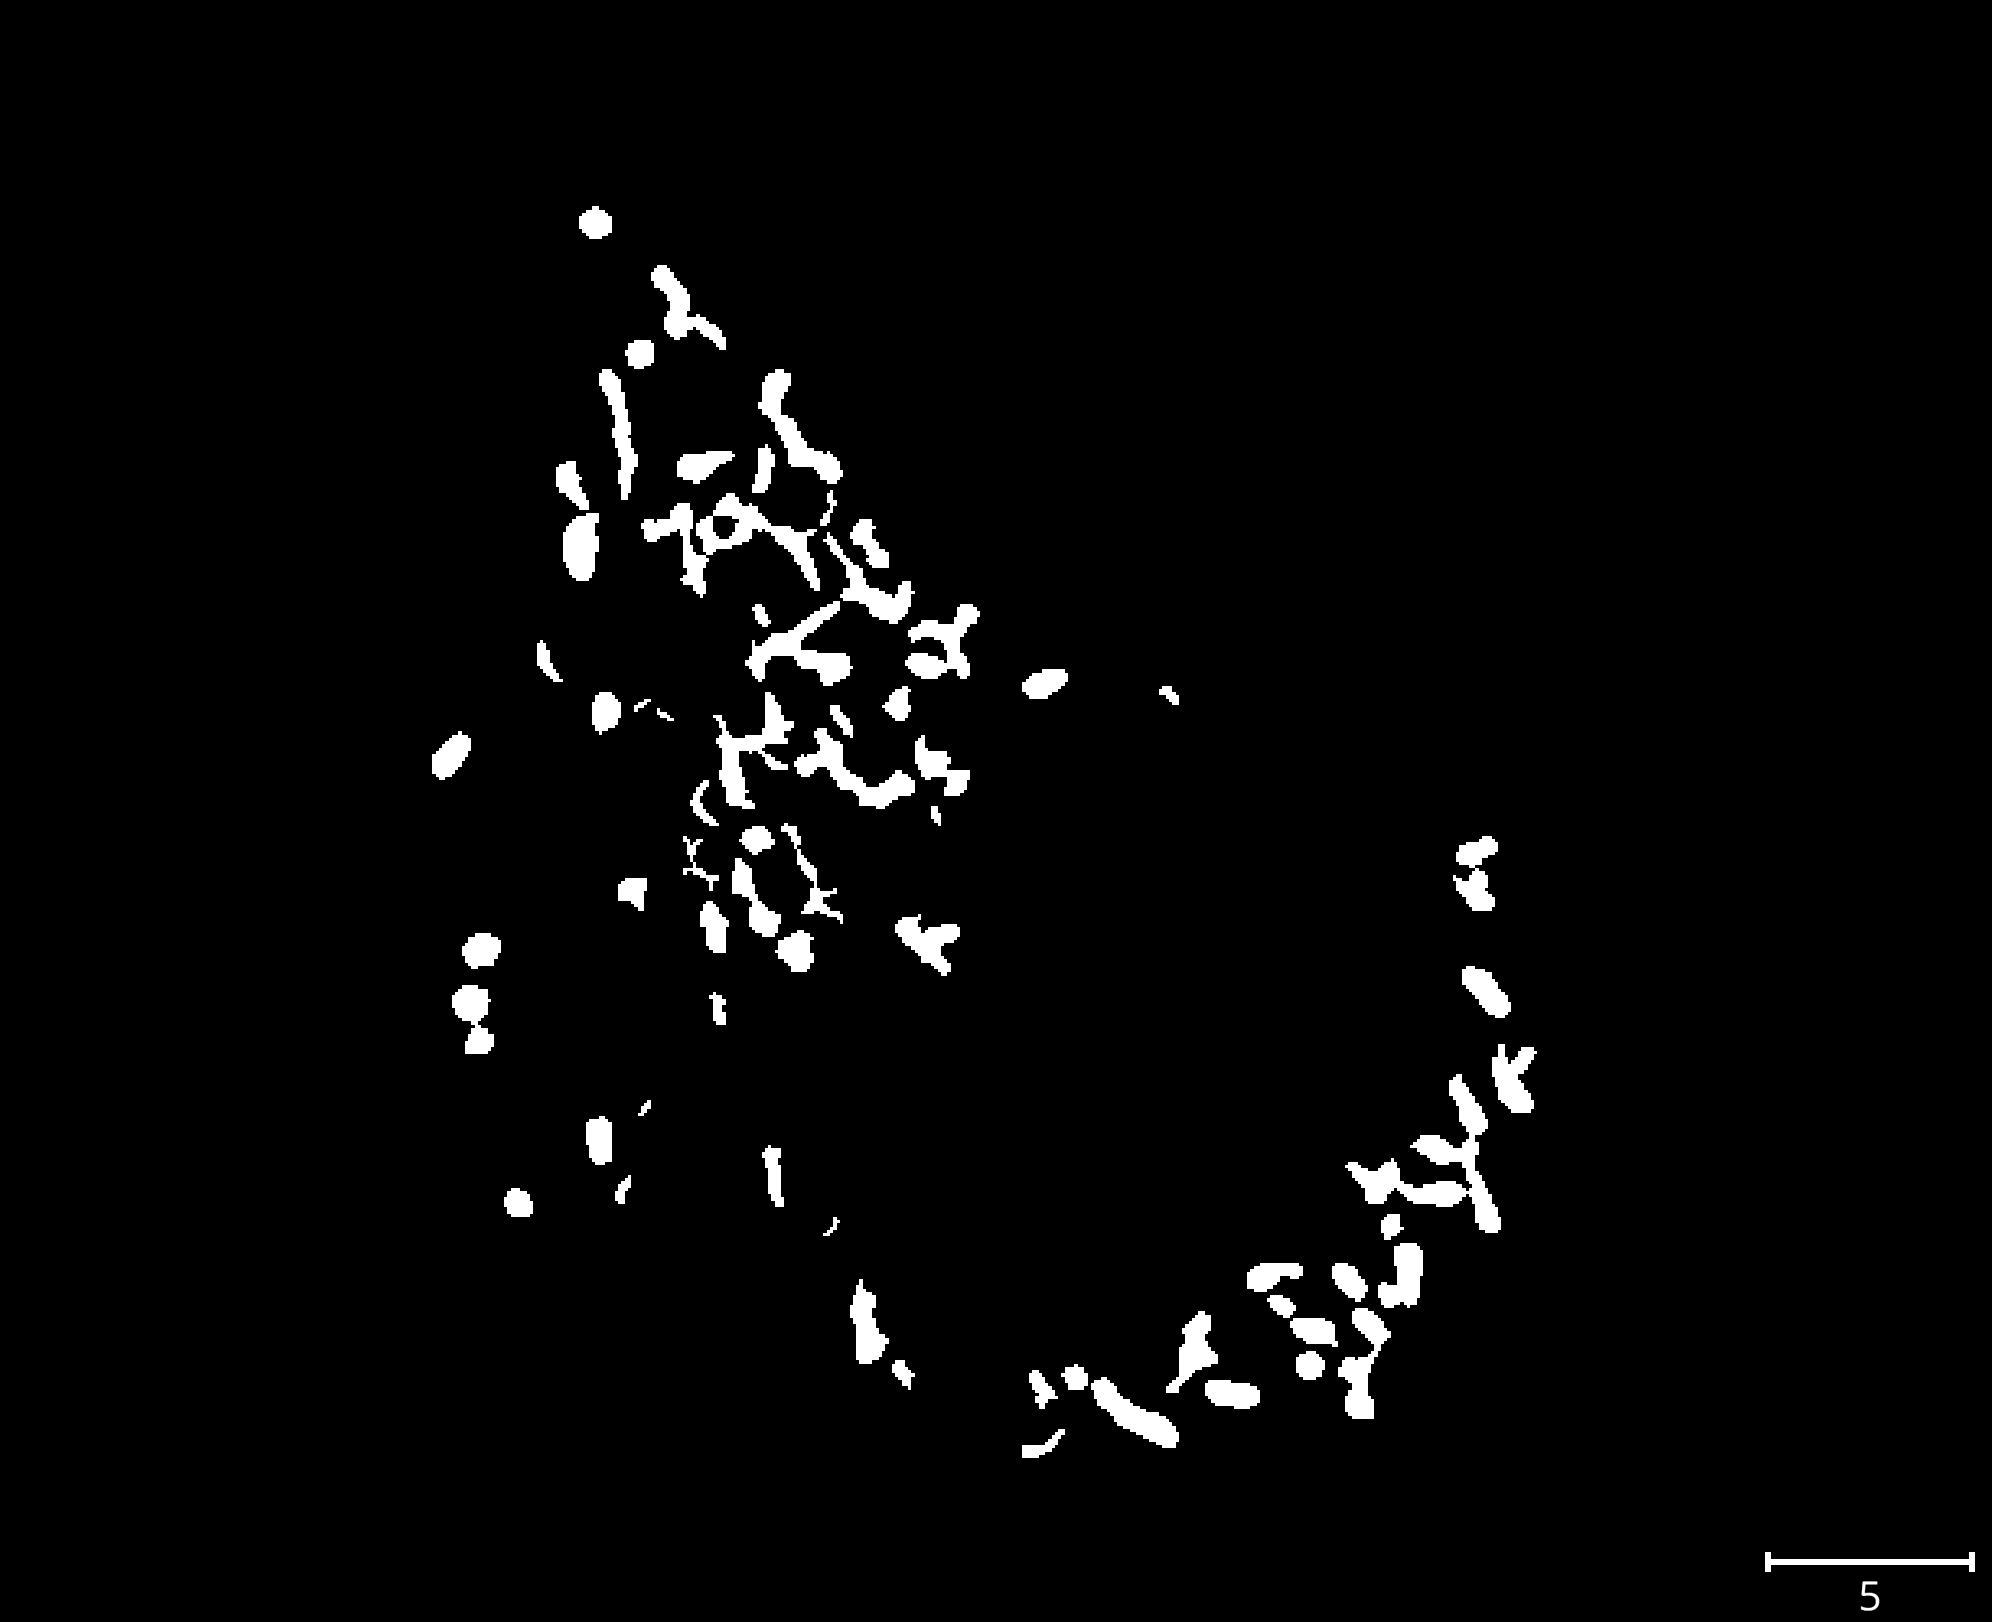

In [18]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

---------------------

 🚧 WIP 🚧 (🚨🚨🚨🚨 )

# PUTATIVE ALTERNATE WORKFLOW #2 (WIP)
as per 6/22 CellProfiler pipeline from MCZ
 > ADAPTIVE... not sure exactly how to impliment this...

  >ReduceNoise performs non-local means noise reduction. Instead of only using a neighborhood of pixels around a central pixel for denoising, such as in GaussianFilter, multiple neighborhoods are pooled together. The neighborhood pool is determined by scanning the image for regions similar to the area around the central pixel using a correlation metric and a cutoff value.
   
## summary of steps (Workflow #1 & #2)

INPUT
- ch 3
- CY mask

PRE-PROCESSING
-  non-local noise reduction
  - size:4, distance:2, cut-off:0.1

CORE-PROCESSING
  - adaptive Otsu
    - diameter: (2,200)
  - two classes
    - threshold smoothing scale: 0
    - threshold correction factor: .1
    - threshold bounds: (0.14 1)
    - adaptive window: 20 pixels

POST-PROCESSING
  - N/A





### INPUT

In [ ]:

###################
# INPUT
###################
raw_mito    = img_2D[2].copy()

# mask object
masked_mito = apply_mask(raw_mito,CY_object)


### PRE-PROCESSING

In [ ]:
###################
# PRE_PROCESSING
###################

intensity_norm_param = [0] # 

# Linear-ish smoothing
raw_mito = intensity_normalization( masked_mito ,  scaling_param=intensity_norm_param)

med_filter_size =3  

gaussian_smoothing_sigma = 1.3
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter(raw_mito,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


# log_img, d = log_transform( structure_img_smooth ) 
# struct_img = intensity_normalization(  log_img  ,  scaling_param=[0] )  

struct_img = structure_img_smooth

### CORE PROCESSING

In [ ]:
###################
# CORE_PROCESSING
###################
# enhance spreckles - 40
big_struct_rad = 40
big_img = enhance_speckles(struct_img.copy(),big_struct_rad, True)

#adaptive_otsu(big_struct) # three class - middle foreground
# adaptive window- 20
#size: 10,100
# threshold smooth 1.34
# threshold correction 1
# threshold (0.1497,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 10
bw_big, _bw_low_level = MO(big_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)

In [ ]:

# enhance speckles
#   adaptive_sauvola(sm_struct) 
# adaptive window- 10
#size: 2,10
# threshold smooth 1.34
# threshold correction 1
# threshold (0.05,1)
#fill holes

# enhance spreckles - 10
sm_struct_rad = 20
sm_img = enhance_speckles(struct_img.copy(),sm_struct_rad, True)

# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 2
bw_sm, _bw_low_level = MO(sm_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)
#     threshold_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*threshold_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold



### POST-PROCESSING

In [ ]:
###################
# POST_PROCESSING
###################


# 3D
# cleaned_img = remove_small_objects(removed_holes>0, 
#                                                             min_size=minArea, 
#                                                             connectivity=1, 
#                                                             in_place=False)
small_object_max = 10
cleaned_img_big = size_filter(bw_big, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_max**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)


#                                                             in_place=False)
small_object_max = 2
cleaned_img_sm = size_filter(bw_sm, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_max**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)



cleaned_img = np.logical_or(cleaned_img_big, cleaned_img_sm)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [ ]:


viewer.add_image(
    cleaned_img,
    scale=scale
)

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img_big,
    scale=scale
)

viewer.add_image(
    big_img,
    scale=scale
)
viewer.add_image(
    cleaned_img_big,
    scale=scale
)
viewer.add_image(
    sm_img,
    scale=scale
)